In [ ]:
import requests
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class GitHubRepository:
    def __init__(self, name, owner,  description, homepage, license, forks, watchers, date_of_collection):
        self.name = name
        self.owner = owner
        self.description = description
        self.homepage = homepage
        self.license = license  # License could be another class with its own attributes
        self.forks = forks
        self.watchers = watchers
        self.date_of_collection = date_of_collection

    @staticmethod
    def parse(dict):
        name = dict['name'] if 'name' in dict else None
        owner = dict['owner']['login'] if 'owner' in dict and 'login' in dict['owner'] else None
        description = dict['description'] if 'description' in dict else None
        homepage = dict['homepage'] if 'homepage' in dict else None
        forks = dict['forks'] if 'forks' in dict else None
        watchers = dict['watchers'] if 'watchers' in dict else None
        license = dict['license']['name'] if 'license' in dict and dict['license'] != None and 'name' in dict['license'] else None

        #get current time in UTC

        time = datetime.now()
        formatted_time = time.strftime("%Y-%m-%dT%H:%M:%SZ")

        return GitHubRepository(name, owner, description, homepage, license, forks, watchers, formatted_time)

    def __str__(self):
        return f'{self.owner}/{self.name}: license = [{self.license}], homepage = [{self.homepage}], forks = ({self.forks}), watchers = ({self.watchers}), date of collection: {self.date_of_collection} \nDescription:\n"{self.description}"'

    def save_as_csv(self):
        data = f'{self.name},{self.owner},{self.description},{self.homepage},{self.license},' \
               f'{self.forks},{self.watchers},{self.date_of_collection}\n'
        save_as_csv('repositories.csv', data)

In [ ]:
class PullRequest:
    def __init__(self,user, title, number, body, state, created_at, closed_at):
        self.user = user
        self.title = title
        self.number = number
        self.body = body
        self.state = state
        self.created_at = created_at
        self.closed_at = closed_at

    def get_creation_day_month_year(self):
      created_date = datetime.strptime(self.created_at, '%Y-%m-%dT%H:%M:%SZ')
      return (created_date.day, created_date.month, created_date.year)

    def save_as_csv(self, repository):
        data = f'{self.number},{repository.name},{repository.owner},{self.title},{self.state},' \
               f'{self.created_at},{self.closed_at},{self.user},{self.commits},{self.additions},' \
               f'{self.deletions},{self.changed_files}\n'
        save_as_csv(f'repos/{repository.owner}-{repository.name}.csv', data)

    @staticmethod
    def parse(dict):
        title = dict['title'] if 'title' in dict else None
        user = dict['user']['login'] if 'user' in dict and 'login' in dict['user'] else None
        number = dict['number'] if 'number' in dict else None
        body = dict['body'] if 'body' in dict else None
        state = dict['state'] if 'state' in dict else None
        created_at = dict['created_at'] if 'created_at' in dict else None
        closed_at = dict['closed_at'] if 'closed_at' in dict else None

        return PullRequest(user,title,number,body,state,created_at,closed_at)

    def __str__(self):
        return f"{self.user}/{self.title}: ({self.state}) ({self.number}) ({self.created_at}) ({self.closed_at})"

In [ ]:
class PRStatus:
    def __init__(self,number,commits,additions,deletions,changed_files):
        self.number = number
        self.commits = commits
        self.additions = additions
        self.deletions = deletions
        self.changed_files = changed_files

    @staticmethod
    def parse(dict):
        number = dict['number'] if 'number' in dict else None
        commits = dict['commits'] if 'commits' in dict else None
        additions = dict['additions'] if 'additions' in dict else None
        deletions = dict['deletions'] if 'deletions' in dict else None
        changed_files = dict['changed_files'] if 'changed_files' in dict else None

        return PRStatus(number,commits,additions,deletions,changed_files)

    def __str__(self):
        return f"PullRequest #{self.number}: commits = ({self.commits}) additions = ({self.additions}) deletions = ({self.deletions}) file changes = ({self.changed_files})"

In [ ]:
class UserInfo:
    def __init__(self, name, no_of_repos, followers, following):
        self.name = name
        self.no_of_repos = no_of_repos
        self.followers = followers
        self.following = following

    @staticmethod
    def parse(dict):
        name = dict['name'] if 'name' in dict else None
        no_of_repos = dict['public_repos'] if 'public_repos' in dict else None
        followers = dict['followers'] if 'followers' in dict else None
        following = dict['following'] if 'following' in dict else None

        return UserInfo(name, no_of_repos, followers, following)

    def set_contributions(self,contributions):
        self.contributions = contributions

    def __str__(self):
        return f'{self.name}: public repositories = {self.no_of_repos}, followers = {self.followers}, following = {self.following}, contributions in last year = {self.contributions}'

    def save_as_csv(self):
            data = f'{self.name},{self.no_of_repos},{self.followers},{self.following},' \
                   f'{self.contributions}\n'
            save_as_csv('users.csv', data)

In [ ]:
# Get Repository

owner = "debsourav33"
repo_name = "Leetcode-Solutions"

def get_repository(owner, repo) -> GitHubRepository :

    url = f"https://api.github.com/repos/{owner}/{repo}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f'Status code {response.status_code} while trying to fetch repository {owner}/{repo}')
        return None

    resp_dict = response.json()
    pretty_response = json.dumps(resp_dict, indent = 4)
    #print(pretty_response)

    return GitHubRepository.parse(resp_dict)

#github_repo = get_repository('ramnes', 'notion-sdk-py')
#print(github_repo)
# github_repo.save_as_csv()

In [ ]:
# Get Pull Request
def getPullRequests(owner, repo):
    url = f"https://api.github.com/repos/{owner}/{repo}/pulls"
    #print(url)
    response = requests.get(url)

    if response.status_code != 200:
        print(f'Status code {response.status_code} while trying to fetch PRs for repository {owner}/{repo}')
        return None
    else:
        resp_list = response.json()
    #print(len(resp_list))
    ret = []
    for item in resp_list:
        pr= PullRequest.parse(item)
        ret.append(pr)
        #print(pr)
    return ret


def getPullRequestInfo(owner, repo, number):
    url = f"https://api.github.com/repos/{owner}/{repo}/pulls/{number}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to retrieve pull requests. Status code: {response.status_code}")
        return None
    else:
        resp_dict = response.json()
        #print(type(resp_dict))
        #print(resp_dict)
        pr_info = PRStatus.parse(resp_dict)
        #print(pr_info)
        return pr_info



owner = "python"
repo = "mypy"

def get_pr_with_status(owner, repo, limit = -1):

  pull_requests = getPullRequests(owner,repo)
  pr_status = []

  if pull_requests != None:
    if limit == -1:
      limit = len(pull_requests)

    for i in range(min(limit,len(pull_requests))):
        pr = pull_requests[i]

        if pr.number != None:
            pr_info = getPullRequestInfo(owner, repo, pr.number)
            pr_status.append(pr_info)
    return pull_requests, pr_status

#pull_requests, pr_status = get_pr_with_status(owner, repo)

In [ ]:
# @title
# Graphs and Plots

def visualize(repo_name, states, commits, additions, deletions, changed_files, users):

  #for simulating closed PRs
  states[0] = 'closed'
  states[1] = 'closed'

  #common features
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))


  # A boxplot that compares closed vs. open pull requests in terms of number of commits

  commits_dict = {'commits':commits, 'states':states}
  df = pd.DataFrame(commits_dict)
  bplot = df.boxplot(by='states',column = 'commits', ax=axes[0, 0], grid = False)
  bplot.plot()

  axes[0, 0].set_title('closed vs. open pull requests for number of commits')

  # A boxplot that compares closed vs. open pull requests in terms of additions

  commits_dict = {'additions':additions, 'states':states}
  df = pd.DataFrame(commits_dict)
  bplot = df.boxplot(by='states',column = 'additions', ax=axes[0, 1], grid = False)
  bplot.plot()

  axes[0, 1].set_title('closed vs. open pull requests for number of  additions')


  # A boxplot that compares closed vs. open pull requests in terms of deletions

  commits_dict = {'deletions':deletions, 'states':states}
  df = pd.DataFrame(commits_dict)
  bplot = df.boxplot(by='states',column = 'deletions', ax=axes[1, 0], grid = False)
  bplot.plot()

  axes[1, 0].set_title('closed vs. open pull requests for number of  deletions')


  # A boxplot that compares the number of changed files grouped by the author association


  map = {'user':users, 'file_changes':changed_files}
  df = pd.DataFrame(map)
  bplot = df.boxplot(by='user',column='file_changes', ax=axes[1, 1], rot = 60)
  bplot.plot()


  axes[1, 1].set_title('number of changed files grouped by the author association')

  #A scatterplot that shows the relationship between additions and deletions
  map = {'additions': additions, 'deletions': deletions}
  df = pd.DataFrame(map)

  ax = df.plot.scatter(x='additions', y='deletions', alpha=0.5, ax=axes[2, 0])

  axes[2, 0].set_title('relationship between additions and deletions per pull_requests')

  #blank 6th plot
  axes[2, 1].axis('off')

  fig.suptitle(f'Data Visualization for Repository "{repo_name}"', fontsize=16)

  plt.tight_layout()

  plt.show()


def plot_graphs(repo, pull_requests, pr_status, limit = -1):
  #limit = min(len(pull_requests), 10) #so that we don't reach api call limit
  #limit = -1
  #pull_requests, pr_status = check_pr(limit)

  if limit == -1:
    limit = len(pr_status)

  states = [pr.state for pr in pull_requests[:limit]]
  commits = [pr.commits for pr in pr_status[:limit]]
  additions = [pr.additions for pr in pr_status[:limit]]
  deletions = [pr.deletions for pr in pr_status[:limit]]
  users = [pr.user for pr in pull_requests[:limit]]
  changed_files = [pr.changed_files for pr in pr_status[:limit]]

  visualize(repo, states, commits, additions, deletions, changed_files, users)

#check_graphs()

In [ ]:
def visualize_all_repo(pull_requests, pr_status):
  pr_per_day = {}
  open_pr_per_day = {}
  closed_pr_per_day = {}

  for i in range(len(pull_requests)):
    pr = pull_requests[i]
    status = pr_status[i]

    date =  pr.get_creation_day_month_year()


    pr_per_day[date] = pr_per_day.get(date,0) + 1

    if status == 'open':
      open_pr_per_day[date] = open_pr_per_day.get(date,0) + 1
    else:
      closed_pr_per_day[date] = closed_pr_per_day.get(date,0) + 1

  #A line graph showing the total number of pull requests per day
  df = pd.DataFrame(data= list(pr_per_day.items()), columns=['date','pull_requests'])
  df = df.set_index('date')
  print(df)
  df.plot(kind='line', marker='o')

  #A line graph comparing number of open and closed pull requests per day
  df_open = pd.DataFrame(data= list(open_pr_per_day.items()), columns=['date','pull_requests'])
  df_closed = pd.DataFrame(data= list(closed_pr_per_day.items()), columns=['date','pull_requests'])
  df_merged = pd.merge(df_open, df_closed, on='date', how='outer').fillna(0)

  # Set 'date' column as the index
  df_merged = df_merged.set_index('date')
  df_merged.plot(kind='line', marker='o')
  plt.legend(['Open PRs', 'Closed PRs'])
  plt.show()

#visualize_all_repo(pull_requests[:limit], pr_status[:limit])

In [ ]:
# Get User Info

user = "jabref"


def getUserInfo(user):
    url = f'https://api.github.com/users/{user}'

    user_info = None

    response = requests.get(url)

    if response.status_code != 200:
        print(f"Status code for fetching user info from {url}: {response.status_code}")
        return None
    else:
        resp_dict = response.json()
        user_info = UserInfo.parse(resp_dict)
            #print(json.dumps(resp_dict,indent = 4))

        #contributions
        url = f"https://api.github.com/users/{user}/events"
        response = requests.get(url)

    if response.status_code != 200:
        print(f"Status code for {url}: {response.status_code}")
    else:
        events = response.json()
        contributions = 0

    for event in events:
        if event.get('type','null') == 'PushEvent':
        #print(json.dumps(event, indent=4))

        #check if the contribution was made this year
          created_at = event.get('created_at','')
          if created_at != '':
              created_year = datetime.strptime(created_at, '%Y-%m-%dT%H:%M:%SZ').year
              curr_year = datetime.now().year

          if curr_year == created_year:
              contributions += 1


    if user_info != None:
        user_info.set_contributions(contributions)

    return user_info

#user_info = getUserInfo(user)
#print(user_info)

Enter the repository name: mypy
Enter the owner name: python

Repository found!
python/mypy: license = [Other], homepage = [https://www.mypy-lang.org/], forks = (2740), watchers = (16814), date of collection: 2023-11-28T21:34:55Z 
Description:
"Optional static typing for Python"


30 pull requests are associated with this repository


PR #16574 created by user: kurtmckee
Kurt McKee: public repositories = 111, followers = 73, following = 0, contributions in last year = 7


PR #16571 created by user: analog-cbarber
Christopher Barber: public repositories = 15, followers = 8, following = 1, contributions in last year = 6


PR #16566 created by user: ikonst
Ilya Priven: public repositories = 93, followers = 56, following = 10, contributions in last year = 10


PR #16562 created by user: JukkaL
Jukka Lehtosalo: public repositories = 9, followers = 347, following = 0, contributions in last year = 5


PR #16559 created by user: JukkaL
Jukka Lehtosalo: public repositories = 9, followers = 347,

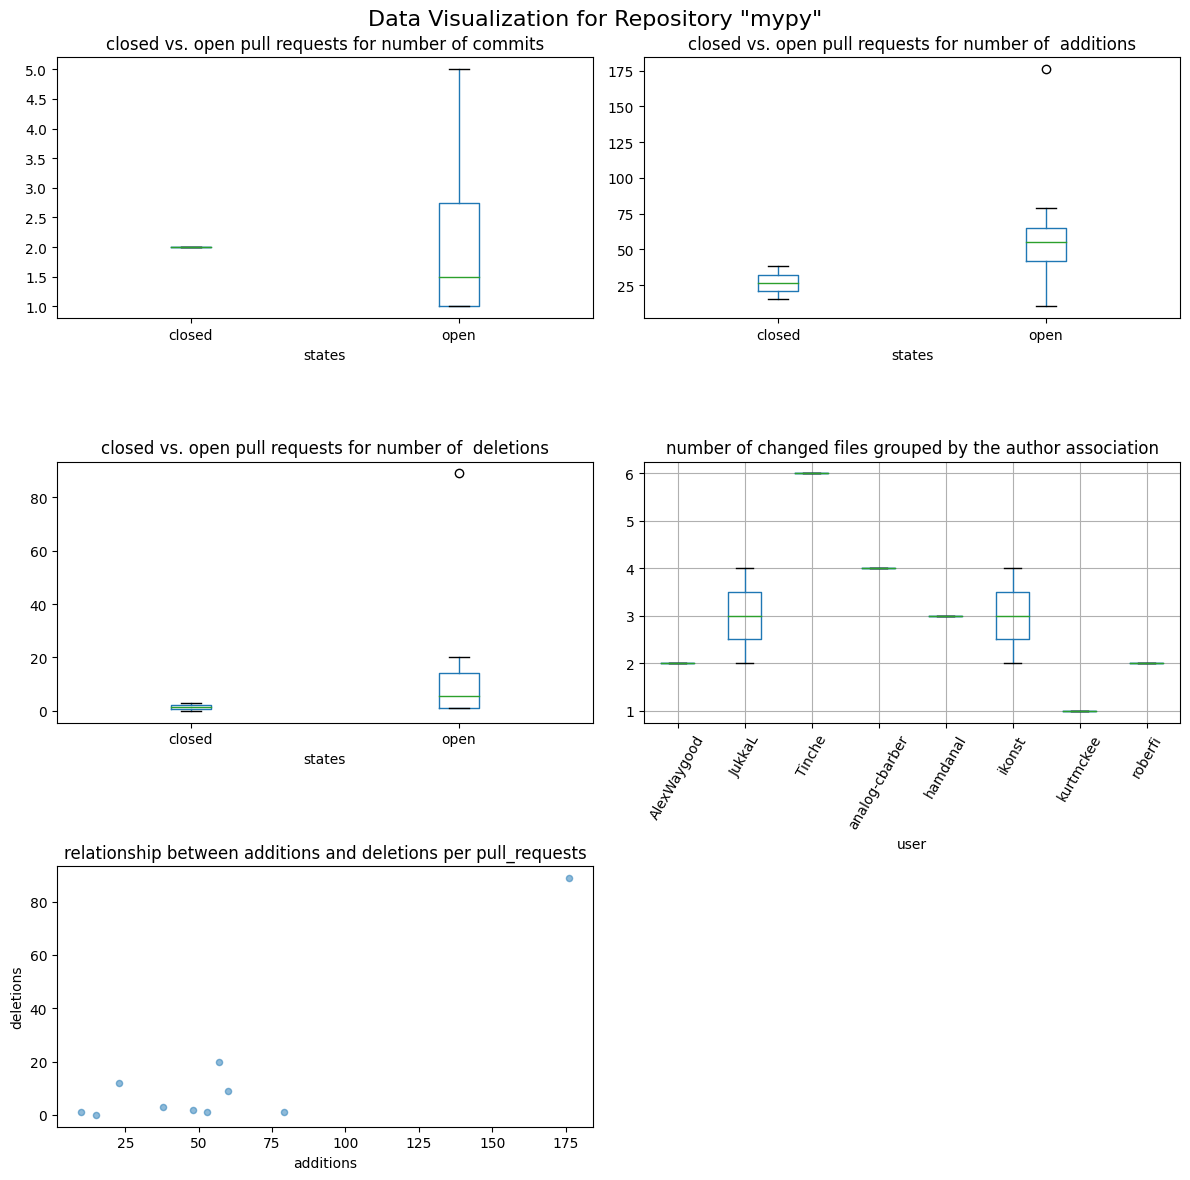


Correlation Matrix
              followers  following  public_repos  contribution
followers      1.000000   0.047874     -0.254437      0.032805
following      0.047874   1.000000      0.080498      0.124472
public_repos  -0.254437   0.080498      1.000000      0.681276
contribution   0.032805   0.124472      0.681276      1.000000



In [ ]:
def main():
  repo_name = input('Enter the repository name: ').lower()
  owner = input('Enter the owner name: ').lower()


  repository = get_repository(owner, repo_name)

  if repository == None:
    print('No such repository found! Please check the repo and owner name.')
  else:
    print('')
    print('Repository found!')
    print(repository)
    print('')



  pull_requests, pr_status = get_pr_with_status(owner,repo_name, limit = 10)

  users = []

  if pull_requests != None:
    count = len(pull_requests)
    print('')
    print(f'{count} pull requests are associated with this repository')
    print('')

    if count>0:

      for pr in pull_requests[:10]:
        print('')
        print(f'PR #{pr.number} created by user: {pr.user}')

        user = getUserInfo(pr.user)
        users.append(user)
        print(user)

        print('')


      print('')
      print('*** Plotting graphs ***')
      print('')


      plot_graphs(repo_name, pull_requests, pr_status)

  else:
    print("Can't find any pull requests for this repository")


  if len(users) > 0:
    data = {
        'followers' : [user.followers for user in users],
        'following' : [user.following for user in users],
        'public_repos' : [user.no_of_repos for user in users],
        'contribution' : [user.contributions for user in users],
    }

    df = pd.DataFrame(data)
    correlation_matrix = df.corr()

    # Print or use the correlation matrix as needed
    print()
    print('Correlation Matrix')
    print(correlation_matrix)
    print()

main()

In [ ]:
# @title
# import the unittest module
import unittest
from datetime import datetime

# create a test class that inherits from unittest.TestCase
class TestGitHubRepository(unittest.TestCase):

    # use the setUp method to perform any setup actions before each test
    def setUp(self):
        # create a sample dictionary to use as input for the parse method
        self.sample_dict = {
            "name": "python-testing",
            "owner": {
                "login": "realpython"
            },
            "description": "A tutorial on testing in Python",
            "homepage": "https://realpython.com/python-testing/",
            "license": {
                "name": "MIT License"
            },
            "forks": 42,
            "watchers": 100
        }

    # write test methods that start with the word test
    def test_init(self):
        # test the __init__ method of the class
        repo = GitHubRepository("python-testing", "realpython", "A tutorial on testing in Python", "https://realpython.com/python-testing/", "MIT License", 42, 100, "2023-11-21T13:29:55Z")
        # use assert methods to check the expected output or behavior of the code under test
        self.assertEqual(repo.name, "python-testing")
        self.assertEqual(repo.owner, "realpython")
        self.assertEqual(repo.description, "A tutorial on testing in Python")
        self.assertEqual(repo.homepage, "https://realpython.com/python-testing/")
        self.assertEqual(repo.license, "MIT License")
        self.assertEqual(repo.forks, 42)
        self.assertEqual(repo.watchers, 100)
        self.assertEqual(repo.date_of_collection, "2023-11-21T13:29:55Z")

    def test_parse(self):
        # test the parse method of the class
        repo = GitHubRepository.parse(self.sample_dict)
        # check that the attributes are assigned correctly from the dictionary
        self.assertEqual(repo.name, "python-testing")
        self.assertEqual(repo.owner, "realpython")
        self.assertEqual(repo.description, "A tutorial on testing in Python")
        self.assertEqual(repo.homepage, "https://realpython.com/python-testing/")
        self.assertEqual(repo.license, "MIT License")
        self.assertEqual(repo.forks, 42)
        self.assertEqual(repo.watchers, 100)
        # check that the date_of_collection is the current time in UTC
        time = datetime.now()
        formatted_time = time.strftime("%Y-%m-%dT%H:%M:%SZ")
        self.assertEqual(repo.date_of_collection, formatted_time)

    def test_str(self):
        # test the __str__ method of the class
        repo = GitHubRepository.parse(self.sample_dict)
        # check that the string representation is formatted correctly
        expected_str = "realpython/python-testing: license = [MIT License] homepage = [https://realpython.com/python-testing/] forks = (42) watchers = (100) date of collection: " + repo.date_of_collection
        self.assertEqual(str(repo), expected_str)

    # use the tearDown method to perform any cleanup actions after each test
    def tearDown(self):
        # delete the sample dictionary
        del self.sample_dict

# create a test class that inherits from unittest.TestCase
class TestPullRequest(unittest.TestCase):
    # use the setUp method to perform any setup actions before each test
    def setUp(self):
        # create a sample dictionary to use as input for the parse method
        self.sample_dict = {
            "title": "Add unit tests",
            "user": {
                "login": "realpython"
            },
            "number": 42,
            "body": "This pull request adds some unit tests for the GitHubRepository and PullRequest classes.",
            "state": "open",
            "created_at": "2023-11-21T13:29:55Z",
            "closed_at": None
        }

    # write test methods that start with the word test
    def test_init(self):
        # test the __init__ method of the class
        pr = PullRequest("realpython", "Add unit tests", 42, "This pull request adds some unit tests for the GitHubRepository and PullRequest classes.", "open", "2023-11-21T13:29:55Z", None)
        # use assert methods to check the expected output or behavior of the code under test
        self.assertEqual(pr.user, "realpython")
        self.assertEqual(pr.title, "Add unit tests")
        self.assertEqual(pr.number, 42)
        self.assertEqual(pr.body, "This pull request adds some unit tests for the GitHubRepository and PullRequest classes.")
        self.assertEqual(pr.state, "open")
        self.assertEqual(pr.created_at, "2023-11-21T13:29:55Z")
        self.assertEqual(pr.closed_at, None)

    def test_parse(self):
        # test the parse method of the class
        pr = PullRequest.parse(self.sample_dict)
        # check that the attributes are assigned correctly from the dictionary
        self.assertEqual(pr.user, "realpython")
        self.assertEqual(pr.title, "Add unit tests")
        self.assertEqual(pr.number, 42)
        self.assertEqual(pr.body, "This pull request adds some unit tests for the GitHubRepository and PullRequest classes.")
        self.assertEqual(pr.state, "open")
        self.assertEqual(pr.created_at, "2023-11-21T13:29:55Z")
        self.assertEqual(pr.closed_at, None)

    def test_str(self):
        # test the __str__ method of the class
        pr = PullRequest.parse(self.sample_dict)
        # check that the string representation is formatted correctly
        expected_str = "realpython/Add unit tests: (open) (42) (2023-11-21T13:29:55Z) (None)"
        self.assertEqual(str(pr), expected_str)

    # use the tearDown method to perform any cleanup actions after each test
    def tearDown(self):
        # delete the sample dictionary
        del self.sample_dict

# create a test class that inherits from unittest.TestCase
class TestPRStatus(unittest.TestCase):

    # use the setUp method to perform any setup actions before each test
    def setUp(self):
        # create a sample dictionary to use as input for the parse method
        self.sample_dict = {
            "number": 42,
            "commits": 3,
            "additions": 100,
            "deletions": 50,
            "changed_files": 5
        }

    # write test methods that start with the word test
    def test_init(self):
        # test the __init__ method of the class
        pr_status = PRStatus(42, 3, 100, 50, 5)
        # use assert methods to check the expected output or behavior of the code under test
        self.assertEqual(pr_status.number, 42)
        self.assertEqual(pr_status.commits, 3)
        self.assertEqual(pr_status.additions, 100)
        self.assertEqual(pr_status.deletions, 50)
        self.assertEqual(pr_status.changed_files, 5)

    def test_parse(self):
        # test the parse method of the class
        pr_status = PRStatus.parse(self.sample_dict)
        # check that the attributes are assigned correctly from the dictionary
        self.assertEqual(pr_status.number, 42)
        self.assertEqual(pr_status.commits, 3)
        self.assertEqual(pr_status.additions, 100)
        self.assertEqual(pr_status.deletions, 50)
        self.assertEqual(pr_status.changed_files, 5)

    def test_str(self):
        # test the __str__ method of the class
        pr_status = PRStatus.parse(self.sample_dict)
        # check that the string representation is formatted correctly
        expected_str = "PullRequest #42: commits = (3) additions = (100) deletions = (50) file changes = (5)"
        self.assertEqual(str(pr_status), expected_str)

    # use the tearDown method to perform any cleanup actions after each test
    def tearDown(self):
        # delete the sample dictionary
        del self.sample_dict

# create a test class that inherits from unittest.TestCase
class TestUserInfo(unittest.TestCase):
    # use the setUp method to perform any setup actions before each test
    def setUp(self):
        # create a sample dictionary to use as input for the parse method
        self.sample_dict = {
            "name": "realpython",
            "public_repos": 10,
            "followers": 1000,
            "following": 50
        }

    # write test methods that start with the word test
    def test_init(self):
        # test the __init__ method of the class
        user_info = UserInfo("realpython", 10, 1000, 50)
        # use assert methods to check the expected output or behavior of the code under test
        self.assertEqual(user_info.name, "realpython")
        self.assertEqual(user_info.no_of_repos, 10)
        self.assertEqual(user_info.followers, 1000)
        self.assertEqual(user_info.following, 50)

    def test_parse(self):
        # test the parse method of the class
        user_info = UserInfo.parse(self.sample_dict)
        # check that the attributes are assigned correctly from the dictionary
        self.assertEqual(user_info.name, "realpython")
        self.assertEqual(user_info.no_of_repos, 10)
        self.assertEqual(user_info.followers, 1000)
        self.assertEqual(user_info.following, 50)

    def test_set_contributions(self):
        # test the set_contributions method of the class
        user_info = UserInfo.parse(self.sample_dict)
        # set the contributions attribute to a sample value
        user_info.set_contributions(500)
        # check that the attribute is updated correctly
        self.assertEqual(user_info.contributions, 500)

    def test_str(self):
        # test the __str__ method of the class
        user_info = UserInfo.parse(self.sample_dict)
        # set the contributions attribute to a sample value
        user_info.set_contributions(500)
        # check that the string representation is formatted correctly
        expected_str = "realpython: repos = 10, followers = 1000, following = 50, contributions in last year = 500"
        self.assertEqual(str(user_info), expected_str)

    # use the tearDown method to perform any cleanup actions after each test
    def tearDown(self):
        # delete the sample dictionary
        del self.sample_dict

# run the unit test using the unittest.main function with some arguments to avoid errors
unittest.main(argv=['first-arg-is-ignored'], exit=False)
